In [1]:
import pandas as pd
import numpy as np
import gc
calendar = pd.read_csv("drive/My Drive/calendar.csv")
sales = pd.read_csv("drive/My Drive/sales_train_evaluation.csv")
print("calendar shape:" , calendar.shape, "\nsales shape:", sales.shape)

calendar shape: (1969, 14) 
sales shape: (30490, 1947)


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

In [3]:
reduce_mem_usage(calendar)

Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.12 MB
Decreased by 41.9%


In [4]:
from tqdm import tqdm
days_col = sales.columns[sales.columns.str.contains(r'd_\d*')] 
def ts_agg(df, grp, i):
    if 'X' in grp and 'Total' not in grp:
        agg_col = grp[np.where(np.array(grp) != 'X')[0][0]]
        fn = df[np.append(agg_col, days_col)].set_index(agg_col).groupby(agg_col).apply(sum).reset_index()
        fn['id2'] = 'X'
        fn['id'] = fn[np.array([agg_col, 'id2'])].apply(lambda x: '_'.join(x), axis = 1).values
        #fn.drop([agg_col, 'id2'], inplace = True, axis = 1)
        
    elif 'Total' in grp:
        df['id'] = 'Total_X'
        fn = df[np.append('id', days_col)].set_index('id').groupby('id').apply(sum).reset_index()
        
        
    else:
        fn = df[np.append(grp, days_col)].set_index(grp).groupby(grp).apply(sum).reset_index()
        fn['id'] = fn[grp].apply(lambda x: '_'.join(x), axis = 1).values
        #fn.drop(grp, inplace = True, axis = 1)
    
    fn['lvl'] = i 
        
    return(fn)
### DETERMINE AGGREGATED SALES ####
levels = (['Total','X'], ['state_id', 'X'], ['store_id', 'X'], ['cat_id', 'X'], ['dept_id', 'X'], 
          ['state_id', 'cat_id'], ['state_id', 'dept_id'], ['store_id', 'cat_id'], ['store_id', 'dept_id'], 
          ['item_id', 'X'], ['state_id', 'item_id'], ['item_id', 'store_id'])

agg_sales_list = []
for i, lv in tqdm(enumerate(levels)):
    agg_sales_list.append(ts_agg(sales, lv, i + 1))


12it [00:34,  2.89s/it]


In [5]:
agg_sales_all = pd.concat(agg_sales_list)
agg_sales_all.reset_index(drop = True, inplace = True)
agg_sales_all.head()

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,...,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941,lvl,state_id,id2,store_id,cat_id,dept_id,item_id
0,Total_X,32631,31749,23783,25412,19146,29211,28010,37932,32736,25572,23071,23658,23756,26445,34833,36380,21804,24070,21443,20318,23721,31689,29283,23966,20501,20757,20277,22529,29908,28707,21240,22872,22046,23475,23572,31202,34876,24562,22752,...,35343,35033,40517,48962,49795,38793,35487,34445,34732,42896,50429,53032,43181,44314,39601,40763,43805,54239,45609,46400,39379,42248,40503,44073,54308,59921,42362,38777,37096,36963,42552,51518,54338,1,NaN,NaN,NaN,NaN,NaN,NaN
1,CA_X,14195,13805,10108,11047,9925,11322,12251,16610,14696,11822,10933,10350,11204,11354,14610,15630,9044,9496,8844,7835,10025,13870,13465,11997,9130,8941,8514,9847,13652,12491,9196,9782,9537,9710,10444,13784,16057,10953,10299,...,15148,14488,17095,21834,23187,17524,15012,14836,14664,17180,22327,23689,19117,17830,17266,16197,17638,23119,19960,18916,16971,16191,15498,18471,23037,24704,17721,16150,15678,16297,17430,23103,24644,2,CA,X,NaN,NaN,NaN,NaN
2,TX_X,9438,9630,6778,7381,5912,9006,6226,9440,9376,7319,6224,6740,6109,7202,10081,11725,6719,7460,6606,6412,6711,9150,9789,7297,6628,5814,6175,6286,8586,9086,6555,7082,6145,6639,6584,9238,10423,7623,6335,...,9600,9602,10615,12266,12282,10662,9933,9575,9655,12162,12694,14193,10719,11949,9909,10833,11773,13668,11385,12035,10580,11314,11491,12320,12366,16249,12228,11370,10375,9162,12303,13681,14815,2,TX,X,NaN,NaN,NaN,NaN
3,WI_X,8998,8314,6897,6984,3309,8883,9533,11882,8664,6431,5914,6568,6443,7889,10142,9025,6041,7114,5993,6071,6985,8669,6029,4672,4743,6002,5588,6396,7670,7130,5489,6008,6364,7126,6544,8180,8396,5986,6118,...,10595,10943,12807,14862,14326,10607,10542,10034,10413,13554,15408,15150,13345,14535,12426,13733,14394,17452,14264,15449,11828,14743,13514,13282,18905,18968,12413,11257,11043,11504,12819,14734,14879,2,WI,X,NaN,NaN,NaN,NaN
4,CA_1_X,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,2995,2710,2928,3078,4316,4354,2757,2430,2272,2009,3015,4553,3966,3264,2441,2377,2414,2701,3719,3548,2246,2549,2559,2568,2978,4096,4832,3138,2997,...,3722,3709,4387,5577,6113,4472,3703,3715,3618,4573,5898,6397,4794,4594,4234,3918,4804,6069,5212,4859,4104,3982,4049,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289,3,NaN,X,CA_1,NaN,NaN,NaN


In [6]:
agg_sales_all['wt'] = agg_sales_all.loc[:,days_col] \
.apply(lambda x: np.abs(x- x.shift(1)).mean(), axis = 1)
agg_sales_all['wt']

0        4278.666495
1        1969.115979
2        1348.466495
3        1439.687113
4         651.286598
            ...     
42835       0.388144
42836       0.197938
42837       0.152577
42838       0.064948
42839       0.226804
Name: wt, Length: 42840, dtype: float64

Add dummy sales columns (from day 1942 to 1969) to facilitate creation of evaluation days features 

In [7]:
d_cols_eval = ['d_' + str(i) for i in range(1942, 1970)] 
for d in d_cols_eval:
  agg_sales_all[d] = np.nan 

In [8]:
from datetime import datetime
import gc
def create_dataset(start_day, lags):
  days_col = agg_sales_all.columns[
  agg_sales_all.columns.str.contains(r'd_\d*')]

  # determine the minimum day when sales was non-zero  
  agg_sales_all['min_day_sales'] = agg_sales_all.loc[:,days_col] \
  .apply(lambda x: np.min(np.where(x > 0)[0] + 1), axis = 1)

  print("melting the dataset...")
  agg_melt = pd.melt(agg_sales_all.loc[:,list(days_col) + ['id', 'min_day_sales', 'wt']], 
                   var_name = "day", value_name = "sales", 
                   id_vars = ['id', 'min_day_sales', 'wt'])

  start_mem = agg_melt.memory_usage().sum() / 1024**2
  print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
  agg_melt['day'] = agg_melt['day'].str.replace('d_', '').astype(np.int16)
  agg_melt['min_day_sales'] = agg_melt['min_day_sales'].astype(np.int16)
  agg_melt['sales'] = agg_melt['sales'].astype(np.float32)
  agg_melt['wt'] = agg_melt['wt'].astype(np.float32)
  end_mem = agg_melt.memory_usage().sum() / 1024**2
  print('Memory usage of dataframe is {:.2f} MB'.format(end_mem))

  agg_melt.sort_values(by = ["id", "day"], inplace = True)
  agg_melt.reset_index(inplace = True, drop = True)

  print( 'maximum weight:', np.nanmax(agg_melt['wt']), '\nminimum weight:', 
        np.nanmin(agg_melt['wt']))

  agg_melt = agg_melt.loc[
    (agg_melt.min_day_sales <= agg_melt.day) & (agg_melt.day >= start_day)]
  
  agg_melt['scaled'] = agg_melt['sales'] / agg_melt['wt']
  
  # create lagged variables
  print('creating lagged variables...')
  if np.any(np.array(lags) < 28):
    return(print("please pick a lagged variable greater than 28 days")) 
  else:
    for lag in lags:
      lag_name = "lag" + str(lag)
      agg_melt[lag_name] = agg_melt.groupby("id")['scaled'].shift(lag)
    # drop lagged variables with null values 
    lag_vars = agg_melt.columns[agg_melt.columns.str.contains('lag')]
    agg_melt = agg_melt.dropna(subset = lag_vars)

  # remmove unnecessary vars
  print('removing unnecessary variables...')
  agg_melt.drop(columns = ['min_day_sales'], inplace = True)
  gc.collect()


  # prepare calendar variables
  print('preparing calendar variables...')
  calendar = pd.read_csv("drive/My Drive/calendar.csv")
  reduce_mem_usage(calendar)
  calendar['date1'] = calendar.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
  calendar['start_date_year'] = calendar.year.apply(lambda x: datetime.strptime(str(x) + '-01-01', '%Y-%m-%d'))
  calendar['day_of_year'] = calendar['date1'] - calendar['start_date_year']
  calendar['day_of_year'] = calendar['day_of_year'].apply(lambda x: x.days + 1).astype(np.int16)
  calendar['d'] = calendar['d'].str.replace("d_", "").astype(np.int16)
  var_list = ['wday', 'month', 'year', 'd', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI', 'day_of_year']

  # convert events to integers, can be thought of as ordinal encoding, although
  # this might not be a good way to represent it 
  event_cols = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
  calendar[event_cols] = calendar[event_cols].apply(lambda x: x.astype("category").cat.codes)

  print('merging with sales...')
  sales_calendar_merge = pd.merge(calendar[var_list], 
                                  agg_melt, right_on = "day", 
                                  left_on = "d", how = "right") \
                                  .sort_values(by =['id', 'day'], ignore_index  = True)
  sales_calendar_merge.drop(columns = ['d'], inplace=True)                                
  del agg_melt; gc.collect()
  print('dataset shape:', sales_calendar_merge.shape)


  return(sales_calendar_merge)



In [9]:
dataset = create_dataset(start_day=1000, lags=[28, 35, 42, 49, 56, 63])


melting the dataset...
Memory usage of dataframe is 3217.77 MB
Memory usage of dataframe is 1608.89 MB
maximum weight: 4278.6665 
minimum weight: 0.010309278
creating lagged variables...
removing unnecessary variables...
preparing calendar variables...
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.12 MB
Decreased by 41.9%
merging with sales...
dataset shape: (37213892, 22)


Standardize values and make sure that other variables do not have very large ranges.

In [10]:
dataset['year'] -= 2011
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
day_of_year = np.arange(1, 366).reshape((-1, 1)) 
scaler.fit(day_of_year)
dataset['day_of_year_s'] = scaler.transform(dataset.day_of_year.values.reshape(-1, 1))


We now prepare the input data that we will be using for the train, test and validation

In [11]:
train_data = dataset[dataset.day <= 1913]
train_data = train_data[np.isfinite(train_data.wt)]
validation_data = dataset[np.logical_and(dataset.day <= 1941, dataset.day > 1913)]
evaluation_data = dataset[np.logical_and(dataset.day > 1941, dataset.day <= 1969)]



In [12]:
  print('train max day:', np.max(train_data['day']),
      '\nvalidation max day:', np.max(validation_data['day']),
      '\nevaluation max day:', np.max(evaluation_data['day']))



train max day: 1913 
validation max day: 1941 
evaluation max day: 1969


In [13]:
print('train data shape:', train_data.shape,
      '\nvalidation data shape:', validation_data.shape,
      '\nevaluation data shape:', evaluation_data.shape)


train data shape: (34814852, 23) 
validation data shape: (1199520, 23) 
evaluation data shape: (1199520, 23)


In [14]:
evaluation_data.head()

,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_year,id,wt,day,sales,scaled,lag28,lag35,lag42,lag49,lag56,lag63,day_of_year_s
879,3,5,5,-1,-1,-1,-1,0,0,0,144,CA_1_FOODS,465.540192,1942,NaN,NaN,6.214286,6.199250,6.177770,7.030542,5.327145,5.941485,-0.370138
880,4,5,5,-1,-1,-1,-1,0,0,0,145,CA_1_FOODS,465.540192,1943,NaN,NaN,5.408771,5.344329,5.095156,5.823342,5.329293,5.580614,-0.360648
881,5,5,5,-1,-1,-1,-1,0,0,0,146,CA_1_FOODS,465.540192,1944,NaN,NaN,5.299220,5.348625,5.028567,5.795418,4.586070,5.486100,-0.351157
882,6,5,5,-1,-1,-1,-1,0,0,0,147,CA_1_FOODS,465.540192,1945,NaN,NaN,5.254111,5.440991,5.200410,5.262703,5.694460,5.758901,-0.341666
883,7,5,5,-1,-1,-1,-1,0,0,0,148,CA_1_FOODS,465.540192,1946,NaN,NaN,6.512864,6.358205,5.812603,6.747001,6.727668,7.348453,-0.332175


In [15]:
validation_data.head()

,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_year,id,wt,day,sales,scaled,lag28,lag35,lag42,lag49,lag56,lag63,day_of_year_s
851,3,4,5,-1,-1,-1,-1,0,0,0,116,CA_1_FOODS,465.540192,1914,2893.0,6.214286,5.327145,5.941485,5.960817,6.394722,5.294924,5.297072,-0.635879
852,4,4,5,-1,-1,-1,-1,0,0,0,117,CA_1_FOODS,465.540192,1915,2518.0,5.408771,5.329293,5.580614,4.732137,5.773938,5.163894,5.168190,-0.626388
853,5,4,5,-1,-1,-1,-1,0,0,0,118,CA_1_FOODS,465.540192,1916,2467.0,5.299220,4.586070,5.486100,5.073676,5.355069,5.230483,4.459336,-0.616897
854,6,4,5,-1,-1,-1,-1,0,0,0,119,CA_1_FOODS,465.540192,1917,2446.0,5.254111,5.694460,5.758901,4.749321,5.393734,5.294924,4.674140,-0.607406
855,7,4,5,-1,-1,-1,-1,0,0,0,120,CA_1_FOODS,465.540192,1918,3032.0,6.512864,6.727668,7.348453,5.904968,6.089700,6.089700,5.827639,-0.597916


prepare one-hot encoding indices for `id` values:  

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

def one_hot_fn(id_arr, ret_vocab = False):
  unique_ids = id_arr.unique()
  len_unique_ids = id_arr.value_counts().set_axis(unique_ids).values 
  stri_split = tf.strings.split(unique_ids, sep = "_")
  vocab, idx = tf.unique(stri_split.flat_values)
  encoded_ids = [one_hot(d, tf.size(vocab).numpy()) for d in unique_ids]
  max_length = np.max([len(i) for i in encoded_ids])
  padded_encoded = np.array(pad_sequences(encoded_ids, maxlen=max_length, padding='post'))
  padded_encoded = np.repeat(padded_encoded, len_unique_ids, axis = 0)

  if ret_vocab:
    return padded_encoded, vocab 
  else:
    return padded_encoded

train_id_enc, vocab = one_hot_fn(train_data['id'], ret_vocab = True)
validation_id_enc = one_hot_fn(validation_data['id'])
eval_id_enc = one_hot_fn(evaluation_data['id'])
print(train_id_enc.shape, validation_id_enc.shape, eval_id_enc.shape)

(34814852, 5) (1199520, 5) (1199520, 5)


### Setting up neural network architecture

For this model, let us try a multi-layer perceptron with *n* hidden layers as a baseline. This is unique since we also try to incorporate an embedding layer (to represent the different ids as a dense vector) along the modelling process. 

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return keras.backend.mean(v)


feat_vars = dataset.columns[~dataset.columns.isin(
    ['id', 'sales', 'scaled', 'wt', 'day_of_year', 'day'])]

def create_model(n_hidden_layers, hidden_units, lr):
  
  ts_id_input = layers.Input(shape = (None, ), dtype = 'int32', 
                             name =  "ts_id_input") 
  # represent vocabulary with a 16-d vector                           
  embedding = layers.Embedding(836, 200) 
  encoded_input = embedding(ts_id_input)

  # since there are ids with multiple words, average vectors into single 
  # representation of the phrase
  pooled_input = layers.GlobalAveragePooling1D()(encoded_input)
  num_input = layers.Input(shape = (feat_vars.shape[0],) , dtype = 'float32', 
                              name = 'ts_features')
  concat_layer = layers.concatenate([pooled_input, num_input])

  # involve dropout layer for regularization 
  for i in range(n_hidden_layers):
    if i < (n_hidden_layers - 1) :
      if i == 0:
        mod = layers.Dense(hidden_units, name = 'layer' + str(i),
                          activation = 'relu')(concat_layer)
      else:
        mod = layers.Dense(hidden_units, name = 'layer' + str(i),
                          activation = 'relu')(mod)
      mod = layers.Dropout(0.3)(mod)
      mod = layers.Concatenate(name = "ft"+str(i))([pooled_input, mod])

    elif i == (n_hidden_layers - 1):
      mod = layers.Dense(hidden_units, name = 'layer' + str(i),
                         activation = 'relu')(mod)
  # output final dense layer with 9 outputs equal to the number of quantiles to 
  # be predicted                        
  preds = layers.Dense(9, activation="linear", name="preds")(mod)
  model = keras.Model(inputs = [ts_id_input, num_input], 
                      outputs = [preds])
  optim = keras.optimizers.Adam(learning_rate = lr)                   
  model.compile(loss=qloss, optimizer=optim)
  return(model)

In [18]:
model = create_model(n_hidden_layers = 3, hidden_units = 500, lr = 0.00005)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ts_id_input (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    167200      ts_id_input[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 200)          0           embedding[0][0]                  
__________________________________________________________________________________________________
ts_features (InputLayer)        [(None, 17)]         0                                            
______________________________________________________________________________________________

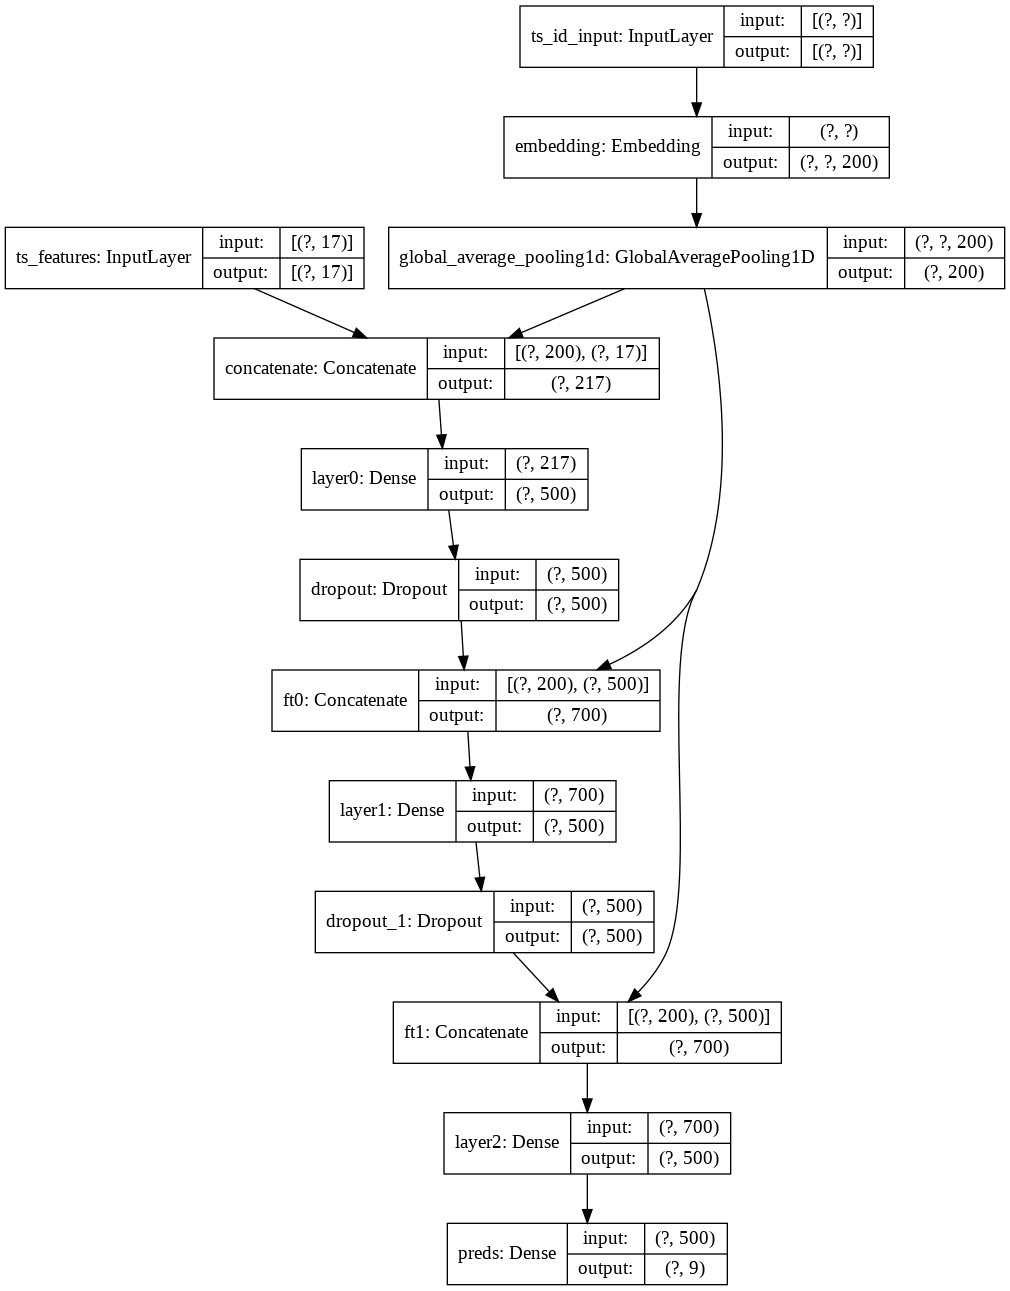

In [20]:
keras.utils.plot_model(model, show_shapes = True)

Defining a number of callbacks to further regulate neural network training  

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping 

ckpt = ModelCheckpoint("weights.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)
es = EarlyStopping(monitor='val_loss', patience=5)

In [22]:
keras.backend.clear_session()
train_data_dict = {'ts_id_input': train_id_enc, 
                   'ts_features':train_data[feat_vars]}
val_data_dict = {'ts_id_input': validation_id_enc, 
                 'ts_features': validation_data[feat_vars]}
                 
history = model.fit(x = train_data_dict, y = train_data['scaled'].values, 
          validation_data = (val_data_dict, validation_data['scaled'].values), 
          batch_size = 200_000, epochs = 20, callbacks = [ckpt, reduce_lr, es])
          

Epoch 1/20
175/175 [==============================] - ETA: 0s - loss: 0.3732
Epoch 00001: val_loss improved from inf to 0.38040, saving model to weights.h5
175/175 [==============================] - 98s 559ms/step - loss: 0.3732 - val_loss: 0.3804 - lr: 5.0000e-05
Epoch 2/20
175/175 [==============================] - ETA: 0s - loss: 0.3055
Epoch 00002: val_loss improved from 0.38040 to 0.37350, saving model to weights.h5
175/175 [==============================] - 98s 558ms/step - loss: 0.3055 - val_loss: 0.3735 - lr: 5.0000e-05
Epoch 3/20
175/175 [==============================] - ETA: 0s - loss: 0.2975
Epoch 00003: val_loss improved from 0.37350 to 0.36901, saving model to weights.h5
175/175 [==============================] - 98s 558ms/step - loss: 0.2975 - val_loss: 0.3690 - lr: 5.0000e-05
Epoch 4/20
175/175 [==============================] - ETA: 0s - loss: 0.2928
Epoch 00004: val_loss improved from 0.36901 to 0.36550, saving model to weights.h5
175/175 [============================

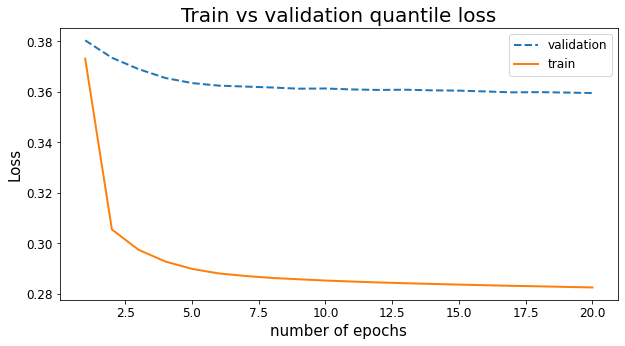

In [23]:
import matplotlib
import matplotlib.pyplot as plt
history_dict = history.history 
mean_q_loss = history_dict['loss']
validation_loss = history_dict['val_loss']

matplotlib.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(1, figsize = (10, 5))
epochs = list(range(1, len(mean_q_loss) + 1))
ax.plot(epochs, validation_loss, linestyle = '--', linewidth = 2,
        label = "validation")
ax.plot(epochs, mean_q_loss, linewidth = 2, label = "train")
ax.set_xlabel('number of epochs', size = 15)
ax.set_ylabel('Loss', size = 15)
#ax.set_ylim([0, np.max(np.append(mean_q_loss, validation_loss))])
ax.legend()
plt.title('Train vs validation quantile loss', size = 20)
plt.show()


In [25]:
fnl = create_model(3, 500, lr = 0.0005)
fnl.load_weights("weights.h5")

In [26]:
eval_data_dict = {'ts_id_input': eval_id_enc, 
                   'ts_features':evaluation_data[feat_vars]}


val_preds = fnl.predict(val_data_dict, batch_size = 50_000) 
eval_preds = fnl.predict(eval_data_dict, batch_size = 50_000) 

print(val_preds.shape, eval_preds.shape)

(1199520, 9) (1199520, 9)


In [27]:
val_preds = val_preds.reshape((-1, 28, 9))
eval_preds = eval_preds.reshape((-1, 28, 9))

print(val_preds.shape, eval_preds.shape)

(42840, 28, 9) (42840, 28, 9)


In [28]:
val_preds

array([[[-1.7796540e-01,  1.6168222e-01,  3.9747882e+00, ...,
          6.6405940e+00,  9.3102674e+00,  1.3173772e+01],
        [-1.5939564e-01,  1.4268734e-01,  3.6590176e+00, ...,
          6.2059255e+00,  8.7230883e+00,  1.2297007e+01],
        [-1.5040141e-01,  1.2525451e-01,  3.4332891e+00, ...,
          5.8838892e+00,  8.3151712e+00,  1.1704018e+01],
        ...,
        [-1.6132706e-01,  1.6919671e-01,  4.6438570e+00, ...,
          7.2581482e+00,  1.0033009e+01,  1.4103478e+01],
        [-2.4119586e-01,  2.4916208e-01,  6.0197763e+00, ...,
          9.1966314e+00,  1.2591353e+01,  1.7988596e+01],
        [-2.2978121e-01,  2.6333991e-01,  6.2999167e+00, ...,
          9.5408106e+00,  1.3005266e+01,  1.8518274e+01]],

       [[-1.5813792e-01,  1.1294285e-01,  3.1591682e+00, ...,
          5.7374263e+00,  8.2271576e+00,  1.1617871e+01],
        [-1.5283424e-01,  6.7673020e-02,  2.5640295e+00, ...,
          5.3475814e+00,  7.8426580e+00,  1.1015403e+01],
        [-1.3661820e-01, 

In [29]:
wts = evaluation_data[['wt', 'id']].drop_duplicates()
wts = wts.wt.values.reshape((-1, 1))
wts

array([[4.6554019e+02],
       [5.6371651e+01],
       [8.4910828e+01],
       ...,
       [2.2319588e-01],
       [3.9175257e-01],
       [1.4396871e+03]], dtype=float32)

In [30]:
QUANTILES = ["0.005", "0.025", "0.165", "0.250", "0.500", "0.750", "0.835", "0.975", "0.995"]

ids = validation_data['id'].unique()
d_cols =  ['F' + str(i) for i in range(1, 29)]

validation = []
evaluation = []

for i, qt in enumerate(QUANTILES):
  val_tmp = pd.DataFrame(val_preds[:, :, i] * wts, columns = d_cols)
  eval_tmp = pd.DataFrame(eval_preds[:, :, i] * wts, columns = d_cols)
  eval_tmp['id'] = ['_'.join([id, qt, 'evaluation']) for id in ids] 
  val_tmp['id'] = ['_'.join([id, qt, 'validation']) for id in ids] 
  validation.append(val_tmp)
  evaluation.append(eval_tmp)


validation_preds = pd.concat(validation).sort_values(by = 'id')
evaluation_preds = pd.concat(evaluation).sort_values(by = 'id')
submission = pd.concat([validation_preds, evaluation_preds])



In [31]:
validation_data.head()

,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,day_of_year,id,wt,day,sales,scaled,lag28,lag35,lag42,lag49,lag56,lag63,day_of_year_s
851,3,4,5,-1,-1,-1,-1,0,0,0,116,CA_1_FOODS,465.540192,1914,2893.0,6.214286,5.327145,5.941485,5.960817,6.394722,5.294924,5.297072,-0.635879
852,4,4,5,-1,-1,-1,-1,0,0,0,117,CA_1_FOODS,465.540192,1915,2518.0,5.408771,5.329293,5.580614,4.732137,5.773938,5.163894,5.168190,-0.626388
853,5,4,5,-1,-1,-1,-1,0,0,0,118,CA_1_FOODS,465.540192,1916,2467.0,5.299220,4.586070,5.486100,5.073676,5.355069,5.230483,4.459336,-0.616897
854,6,4,5,-1,-1,-1,-1,0,0,0,119,CA_1_FOODS,465.540192,1917,2446.0,5.254111,5.694460,5.758901,4.749321,5.393734,5.294924,4.674140,-0.607406
855,7,4,5,-1,-1,-1,-1,0,0,0,120,CA_1_FOODS,465.540192,1918,3032.0,6.512864,6.727668,7.348453,5.904968,6.089700,6.089700,5.827639,-0.597916


In [32]:
submission.head(25)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,id
0,-82.850044,-74.205078,-70.017906,-71.573227,-78.237633,-117.808319,-104.444733,-91.795982,-77.870712,-75.095711,-79.948288,-80.926170,-112.292191,-103.874954,-84.492920,-76.167107,-71.542290,-72.782417,-77.101585,-115.946152,-106.032333,-81.546516,-74.210960,-70.833702,-69.588577,-75.104233,-112.286369,-106.972389,CA_1_FOODS_0.005_validation
0,75.269569,66.426689,58.311008,59.704769,72.984108,99.004868,102.329697,85.689636,71.499756,66.443001,66.741928,82.509285,121.224655,113.150879,84.748589,70.431793,66.330116,65.787338,75.458313,121.312088,120.101929,85.758888,70.482681,65.025330,63.622456,78.767868,115.994965,122.595314,CA_1_FOODS_0.025_validation
0,1850.423706,1703.419678,1598.333984,1687.949097,2087.722656,2446.146240,2648.062744,2039.601074,1841.090942,1725.407715,1791.224243,2259.034668,2923.443604,2610.306396,2113.446533,1764.526978,1740.431519,1787.645386,2151.415771,2842.954590,2965.765625,2031.709229,1730.472656,1691.245728,1728.297485,2161.902100,2802.447754,2932.864502,CA_1_FOODS_0.165_validation
0,2136.655518,1974.187378,1866.467529,1958.279541,2381.572021,2852.819580,3043.270996,2320.347168,2118.000977,1984.096191,2057.267090,2550.330566,3276.204102,3016.061523,2403.352051,2029.988770,2008.682129,2054.052246,2444.682129,3189.468506,3313.065186,2312.112061,1993.854248,1950.207153,1991.110718,2443.178223,3144.440674,3270.803955,CA_1_FOODS_0.250_validation
0,2384.899170,2213.524658,2087.539062,2200.876465,2669.900146,3214.406982,3463.097900,2620.791016,2400.638428,2240.079346,2338.304443,2871.454346,3648.556641,3439.898926,2719.085449,2288.243164,2266.166260,2312.304443,2725.166504,3537.725098,3680.551025,2574.368652,2221.084717,2180.652100,2224.789307,2716.218018,3467.928467,3626.132568,CA_1_FOODS_0.500_validation
0,2855.840332,2662.403320,2517.275146,2638.337891,3136.069824,3757.582275,4027.627441,3117.513184,2869.464600,2676.742676,2760.278809,3338.265381,4222.717285,4028.166016,3220.541992,2742.580322,2712.219238,2752.523682,3174.905273,4103.830078,4240.745605,3048.049805,2658.584961,2608.178467,2647.340576,3150.534424,4006.639648,4179.074707,CA_1_FOODS_0.750_validation
0,3091.463379,2889.107666,2739.187012,2857.201660,3363.838135,4080.188232,4355.307129,3362.914307,3108.293457,2901.978516,3001.885010,3569.220459,4509.186035,4355.031250,3467.474365,2970.649658,2930.918457,2968.129395,3401.344482,4369.783203,4525.204102,3291.457275,2886.653076,2832.029541,2866.427979,3378.959717,4281.401367,4441.630859,CA_1_FOODS_0.835_validation
0,4334.303711,4060.948242,3871.046387,4021.227295,4666.466797,5693.398926,6046.288086,4671.739258,4348.251465,4069.654541,4168.476562,4916.656250,6171.356934,6027.857422,4809.265137,4163.787598,4114.938477,4154.838379,4704.954590,5986.907227,6173.389648,4589.183594,4060.885498,3990.153076,4027.666016,4670.768555,5861.781250,6054.474121,CA_1_FOODS_0.975_validation
0,6132.920410,5724.750977,5448.690430,5642.011719,6568.250977,8081.441406,8551.626953,6600.362793,6145.561035,5721.469238,5866.010254,6929.916016,8794.731445,8503.440430,6820.455566,5880.227539,5803.136719,5845.279297,6625.625488,8556.513672,8817.849609,6516.358398,5732.436523,5618.348633,5653.314941,6565.735840,8374.414062,8621.000977,CA_1_FOODS_0.995_validation
1,-8.914495,-8.615519,-7.701393,-8.752217,-9.158866,-15.258131,-11.266346,-9.005857,-8.475009,-7.385397,-8.885639,-9.932596,-14.495963,-11.630669,-8.665905,-8.239355,-7.194630,-8.509819,-9.178707,-14.956493,-11.495173,-7.911055,-7.369827,-7.338182,-7.915402,-8.343370,-13.333597,-10.688972,CA_1_FOODS_1_0.005_validation


In [33]:
submission.tail(25)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28,id
42837,0.000238,-0.000235,0.000303,-0.000342,0.000613,-0.004498,-0.000730,-0.000467,-0.000589,-0.000851,0.000145,-0.000269,0.000250,-0.000758,-0.000409,-0.000299,-0.000555,-0.000291,-0.000465,-0.000503,0.000491,-0.001584,-0.000250,-0.000407,-0.000090,-0.000047,-0.000666,-0.001199,WI_HOUSEHOLD_2_515_0.165_evaluation
42837,-0.000324,-0.000400,0.000171,-0.000137,-0.000504,0.006357,-0.000417,-0.000196,-0.000389,-0.000417,-0.000035,0.000253,0.001955,-0.000487,0.001057,-0.000161,-0.000345,-0.000154,-0.000261,-0.000410,0.001286,-0.000629,-0.000391,-0.000226,-0.000035,-0.000037,-0.000479,0.000163,WI_HOUSEHOLD_2_515_0.250_evaluation
42837,0.003648,0.000622,0.070663,-0.000093,0.067387,0.362486,-0.000367,-0.000066,-0.000245,-0.000043,0.000005,0.061021,0.131577,-0.000367,0.050246,-0.000207,-0.000263,-0.000074,-0.000217,0.000414,0.048007,-0.000258,0.000729,0.002958,-0.000012,-0.000012,-0.000280,0.078647,WI_HOUSEHOLD_2_515_0.500_evaluation
42837,0.487315,0.439940,0.525745,0.231904,0.526546,0.744506,0.385079,0.257909,0.350871,0.383609,0.143290,0.548425,0.592014,0.398861,0.551785,0.259560,0.329757,0.165834,0.294734,0.440125,0.551211,1.087693,0.455032,0.469178,0.103264,0.098940,0.357899,0.562549,WI_HOUSEHOLD_2_515_0.750_evaluation
42837,0.732524,0.700774,0.744055,0.479494,0.750017,0.942326,0.659706,0.493249,0.619735,0.636630,0.425151,0.766375,0.833068,0.672214,0.781534,0.498905,0.612396,0.446822,0.571419,0.719296,0.781828,1.592279,0.721081,0.724779,0.388448,0.381568,0.643538,0.779335,WI_HOUSEHOLD_2_515_0.835_evaluation
42837,1.573884,1.545949,1.549575,1.272663,1.576537,1.851685,1.505494,1.291019,1.459149,1.447237,1.300861,1.618425,1.711063,1.557215,1.651647,1.202843,1.453084,1.303705,1.395517,1.616839,1.663645,3.578897,1.584094,1.565003,1.236709,1.229844,1.536619,1.620439,WI_HOUSEHOLD_2_515_0.975_evaluation
42837,2.511854,2.506013,2.366235,2.155236,2.414626,2.631670,2.453834,2.211058,2.388522,2.359532,2.343953,2.477411,2.587490,2.559831,2.637012,2.097837,2.411260,2.280976,2.338135,2.607964,2.609849,5.882981,2.558176,2.522953,2.200463,2.199464,2.561968,2.570400,WI_HOUSEHOLD_2_515_0.995_evaluation
42838,-0.022846,-0.023535,-0.022186,-0.018509,-0.014158,-0.030798,-0.028117,-0.026872,-0.023541,-0.023586,-0.022501,-0.014111,-0.030750,-0.028959,-0.020221,-0.021917,-0.022032,-0.018626,-0.015181,-0.016445,-0.019120,-0.014514,-0.022569,-0.021254,-0.020971,-0.021876,-0.021018,-0.025382,WI_HOUSEHOLD_2_516_0.005_evaluation
42838,-0.002712,-0.001659,-0.001603,-0.004427,-0.003722,-0.001797,-0.001786,-0.003145,-0.001663,-0.001760,-0.003277,-0.003555,-0.003615,-0.002006,-0.002515,-0.001677,-0.001719,-0.002252,-0.003226,-0.004705,-0.003094,-0.003648,-0.001698,-0.001653,-0.001769,-0.003671,-0.004862,-0.003569,WI_HOUSEHOLD_2_516_0.025_evaluation
42838,0.001304,-0.000133,-0.000099,-0.000305,0.000041,-0.000301,-0.000266,0.000323,-0.000133,-0.000182,0.001978,-0.000148,0.001036,-0.000423,-0.001131,-0.000288,-0.000151,0.001146,-0.000147,0.001457,0.000991,0.000500,-0.000166,-0.000116,0.001873,-0.000443,-0.000014,-0.000868,WI_HOUSEHOLD_2_516_0.165_evaluation


In [ ]:
submission.to_csv('submission.csv', index=False)

In [37]:
!mkdir -p ~/.kaggle
!cp drive/My\ \Drive/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions submit -c m5-forecasting-uncertainty -f submission.csv -m "using similar scaling factor, 3 hidden layers, 500 units"

kaggle.json
100% 261M/261M [00:05<00:00, 47.3MB/s]
Successfully submitted to M5 Forecasting - UncertaintyWarning: Looks like you're using an outdated API Version, please consider updating (server 1.5.6 / client 1.5.4)
 95% 15.0M/15.8M [00:00<00:00, 31.4MB/s]
100% 15.8M/15.8M [00:00<00:00, 45.6MB/s]
  0% 0.00/2.00M [00:00<?, ?B/s]
100% 2.00M/2.00M [00:00<00:00, 126MB/s]
 32% 5.00M/15.5M [00:00<00:00, 20.4MB/s]
100% 15.5M/15.5M [00:00<00:00, 51.8MB/s]
 35% 5.00M/14.2M [00:00<00:00, 28.4MB/s]
100% 14.2M/14.2M [00:00<00:00, 56.4MB/s]
  0% 0.00/101k [00:00<?, ?B/s]
100% 101k/101k [00:00<00:00, 90.1MB/s]


In [ ]:
!rm -rf .kaggle
